# Query the Nemoretriever OCR v1 API

This notebook demonstrates how to interact with the NVIDIA Nemoretriever OCR v1 NIM container using Python. 
It covers launching the NIM container and sending an inference request with a base64 encoded image.

Reference: [NVIDIA Build - Nemoretriever OCR](https://build.nvidia.com/nvidia/nemoretriever-ocr-v1/deploy)

## 1. Launch NIM

Before running the Python code, you need to launch the Nemoretriever OCR NIM container. 
Run the following command in your terminal:

```bash
export NGC_API_KEY=<PASTE_API_KEY_HERE> 
export LOCAL_NIM_CACHE=~/.cache/nim 
mkdir -p "$LOCAL_NIM_CACHE" 

# Start the OCR NIM 
docker run -it --rm \
  --gpus all \
  --shm-size=16GB \
  -e NGC_API_KEY=$NGC_API_KEY \
  -v "$LOCAL_NIM_CACHE:/opt/nim/.cache" \
  -u $(id -u) \
  -p 8000:8000 \
  nvcr.io/nim/nvidia/nemoretriever-ocr-v1:1.2.1
```

## 2. Install Dependencies

In [ ]:
!pip install requests pillow openai

## 3. Prepare Image

We will download an example image and encode it to base64.

In [1]:
import base64
import requests
from io import BytesIO
from PIL import Image

# Example Image URL (using the same one as before for consistency)
image_url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"

# Download image
response = requests.get(image_url)
image_content = response.content

# Encode to base64
encoded_image = base64.b64encode(image_content).decode("utf-8")
print("Image encoded successfully.")

Image encoded successfully.


## 4. Query the API

Send the base64 encoded image to the local inference API.

In [2]:
import requests
import json

url = "http://localhost:8000/v1/infer"
payload = {
    "input": [
        {
            "type": "image_url",
            "url": f"data:image/png;base64,{encoded_image}"
        }
    ]
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/json"
}

try:
    response = requests.post(url, json=payload, headers=headers)
    response.raise_for_status()
    result = response.json()
    print(json.dumps(result, indent=2))
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")
    print("Ensure the NIM container is running on port 8000.")

{
  "data": [
    {
      "index": 0,
      "text_detections": [
        {
          "text_prediction": {
            "text": "Many support government economic assistance",
            "confidence": 0.9861597573250154
          },
          "bounding_box": {
            "points": [
              {
                "x": 0.006511888932436705,
                "y": 0.031079808250069618
              },
              {
                "x": 0.8955893516540527,
                "y": 0.031079808250069618
              },
              {
                "x": 0.8955893516540527,
                "y": 0.10337691009044647
              },
              {
                "x": 0.006511888932436705,
                "y": 0.10337691009044647
              }
            ]
          }
        },
        {
          "text_prediction": {
            "text": "It is the individual's responsibility to earn a decent standard of living OR itis the government's responsibility to ensure a decent standard of living f

Saved visualization to example_result.png


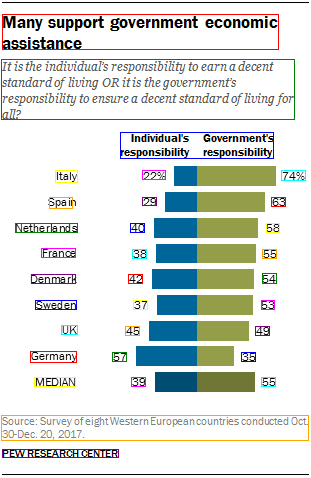

In [5]:
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

# Download the image for visualization
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image.save("example.png")

# --- Convert API response to visualization format ---

# Extract text detections from the API result
text_detections = result["data"][0]["text_detections"]

# Convert bounding box format from 'points' to xmin/ymin/xmax/ymax
detections = []
for detection in text_detections:
    points = detection["bounding_box"]["points"]
    # Points are ordered: top-left, top-right, bottom-right, bottom-left
    x_coords = [p["x"] for p in points]
    y_coords = [p["y"] for p in points]
    
    detections.append({
        "bbox": {
            "xmin": min(x_coords),
            "ymin": min(y_coords),
            "xmax": max(x_coords),
            "ymax": max(y_coords)
        },
        "text": detection["text_prediction"]["text"],
        "confidence": detection["text_prediction"]["confidence"]
    })

# --- Visualization ---

draw = ImageDraw.Draw(image)
width, height = image.size

colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "orange", "purple"]

try:
    font = ImageFont.truetype("arial.ttf", 16)
except IOError:
    font = ImageFont.load_default()

for i, det in enumerate(detections):
    bbox = det["bbox"]
    # Convert normalized coordinates to pixel values
    left = bbox["xmin"] * width
    top = bbox["ymin"] * height
    right = bbox["xmax"] * width
    bottom = bbox["ymax"] * height

    # Choose a color for the box
    color = colors[i % len(colors)]

    # Draw the bounding box with a thin outline
    draw.rectangle([left, top, right, bottom], outline=color, width=1)

image.save("example_result.png")
print("Saved visualization to example_result.png")

# Display the image in notebook
image
